# HMM OF THE DISHONEST CASINO

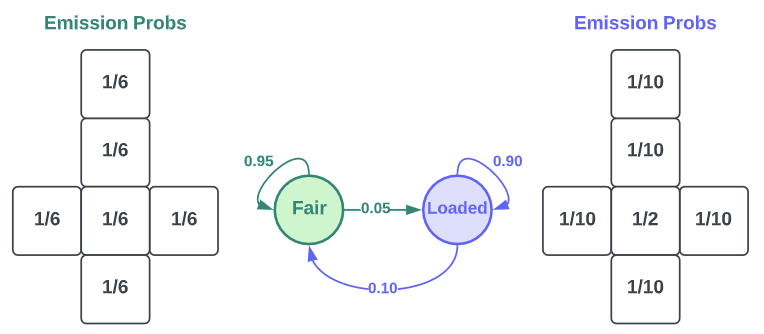

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [3]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax
ssm_jax.__file__

'/Users/scott/Projects/ssm-jax/ssm_jax/__init__.py'

In [4]:
try:
    import graphviz
except ModuleNotFoundError:
    %pip install graphviz

In [6]:
import jax.numpy as jnp
from jax import random
from jax import vmap

import optax

import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt

from ssm_jax.hmm.models import CategoricalHMM

## Initilization

In [7]:
key = random.PRNGKey(0)
init_key, sample_key = random.split(key)

initial_probabilities = jnp.array([1, 1]) / 2

# state transition matrix
transition_matrix = jnp.array([[0.95, 0.05], [0.10, 0.90]])

# observation matrix
emission_probs = jnp.array(
    [
        [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
        [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10],  # loaded die
    ]
).reshape(2, 1, 6)

casino = CategoricalHMM(initial_probabilities, transition_matrix, emission_probs)
sample_fn = vmap(casino.sample, in_axes=(0, None))
n, num_timesteps = 4, 5000
keys = random.split(sample_key, n)
_, emissions = sample_fn(keys, num_timesteps)

## Learning

In [12]:
num_states, num_emissions, num_classes = emission_probs.shape
num_epochs = 400
learning_rate = 1e-1
momentum = 0.95
optimizer = optax.sgd(learning_rate=learning_rate, momentum=momentum)
shuffle = True

### Full-Batch Gradient Descent

In [13]:
batch_size = n
key = random.PRNGKey(0)
hmm_fb = CategoricalHMM.random_initialization(init_key, num_states, num_emissions, num_classes)
losses_fbgd = hmm_fb.fit_sgd(emissions, optimizer=optimizer, batch_size=batch_size, num_epochs=num_epochs, shuffle=shuffle, key=key)

### Mini-Batch Gradient Descent

In [14]:
batch_size = 2
key = random.PRNGKey(0)
hmm_mb = CategoricalHMM.random_initialization(init_key, num_states, num_emissions, num_classes)
losses_mbgd = hmm_mb.fit_sgd(emissions, optimizer=optimizer, batch_size=batch_size, num_epochs=num_epochs, shuffle=shuffle, key=key)

### Stochastic Gradient Descent

In [15]:
batch_size = 1
key = random.PRNGKey(0)
hmm_sgd = CategoricalHMM.random_initialization(init_key, num_states, num_emissions, num_classes)
losses_sgd = hmm_sgd.fit_sgd(emissions, optimizer=optimizer, batch_size=batch_size, num_epochs=num_epochs, shuffle=shuffle, key=key)

### Expectation-Maximization

In [16]:
hmm_em = CategoricalHMM.random_initialization(init_key, num_states, num_emissions, num_classes)
losses_em = hmm_em.fit_em(emissions, num_epochs=num_epochs)
losses_em = np.array(losses_em) * -1

100%|██████████| 50/50 [00:00<00:00, 50.75it/s]


## Results

In [17]:
def hmm_plot_graphviz(trans_mat, obs_mat, states=[], observations=[]):
    """
    Visualizes HMM transition matrix and observation matrix using graphhiz.
    Parameters
    ----------
    trans_mat, obs_mat, init_dist: arrays
    states: List(num_hidden)
        Names of hidden states
    observations: List(num_obs)
        Names of observable events
    Returns
    -------
    dot object, that can be displayed in colab
    """

    n_states, _, n_obs = obs_mat.shape

    dot = Digraph(comment="HMM")
    if not states:
        states = [f"State {i + 1}" for i in range(n_states)]
    if not observations:
        observations = [f"Obs {i + 1}" for i in range(n_obs)]

    # Creates hidden state nodes
    for i, name in enumerate(states):
        table = [f'<TR><TD>{observations[j]}</TD><TD>{"%.2f" % prob}</TD></TR>' for j, prob in enumerate(obs_mat[i,0])]
        label = f"""<<TABLE><TR><TD BGCOLOR="lightblue" COLSPAN="2">{name}</TD></TR>{''.join(table)}</TABLE>>"""
        dot.node(f"s{i}", label=label)

    # Writes transition probabilities
    for i in range(n_states):
        for j in range(n_states):
            dot.edge(f"s{i}", f"s{j}", label=str("%.2f" % trans_mat[i, j]))
    dot.attr(rankdir="LR")
    # dot.render(file_name, view=True)
    return dot

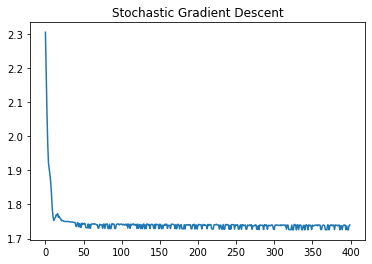

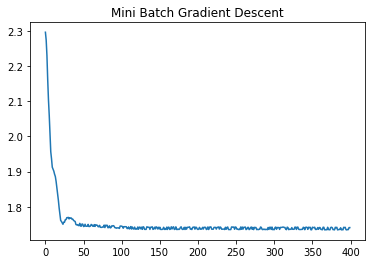

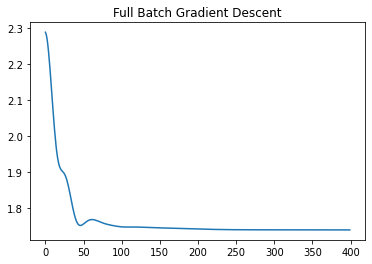

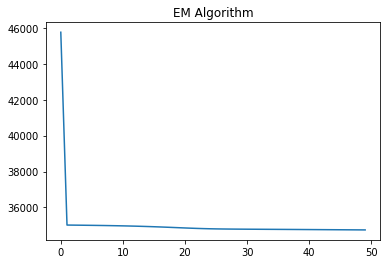

In [18]:
losses = [losses_sgd, losses_mbgd, losses_fbgd, losses_em]

titles = ["Stochastic Gradient Descent", "Mini Batch Gradient Descent", "Full Batch Gradient Descent", "EM Algorithm"]

dict_figures = {}

for loss, title in zip(losses, titles):
    filename = title.replace(" ", "_").lower()
    fig, ax = plt.subplots()
    ax.plot(loss)
    ax.set_title(f"{title}")
    dict_figures[filename] = fig
    plt.savefig(f"{filename}.png", dpi=300)

plt.show()

In [19]:
dotfile = hmm_plot_graphviz(hmm_sgd.transition_matrix.value, hmm_sgd.emission_probs.value)
dotfile.render("hmm-casino-sgd-dot")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
dotfile

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
dotfile = hmm_plot_graphviz(hmm_em.transition_matrix.value, hmm_em.emission_probs.value)
dotfile.render("hmm-casino-em-dot")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
dotfile

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH